The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading /home/facundoq/data/datasets/spectrogram/scans2023/Hu_1057_mu_Cen_mu Cen.png
0.014999628


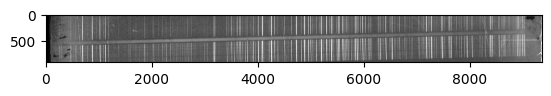

In [252]:
%load_ext autoreload
%autoreload 2
from peak_finding import BackgroundRemoval,Image2SignalDistribution,Pipeline,SavgolFilter,FindPeaks
from pathlib import Path
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread


folder = Path("/home/facundoq/data/datasets/spectrogram/scans2023/")

file = 10
files = list([x for x in folder.iterdir() if x.is_file()])

filepath = files[file]

print(f"Loading {filepath}")


image = 1-imread(filepath)
image = image[400:1300,:]
print(image.min())
plt.imshow(image,cmap="gray")




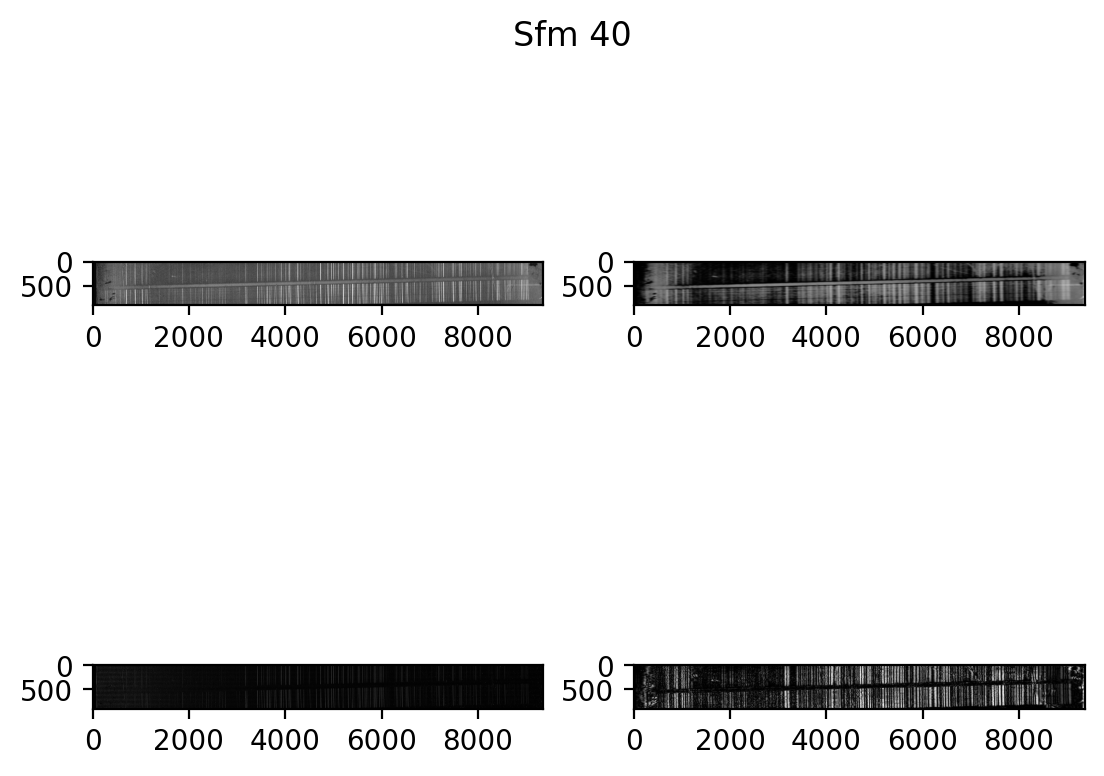

In [250]:


    

for sfm in [ 40,]:
    br_step = BackgroundRemoval(sfm)
    preprocessed_image = br_step(image)
    f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,dpi=200)
    diff = np.abs(np.diff(image,1,axis=1))
    preprocessed_diff = preprocessed_image
    for i in range(1):
        preprocessed_diff = np.abs(np.diff(preprocessed_diff,1,axis=1))
    # preprocessed_diff = gaussian_filter(preprocessed_diff, sigma=(4,20))
    ax1.imshow(image,cmap="gray",vmin=0,vmax=1)
    ax2.imshow(preprocessed_image,cmap="gray",vmin=0,vmax=1)
    ax3.imshow(diff,cmap="gray")
    ax4.imshow(preprocessed_diff,cmap="gray")
    f.suptitle(f"Sfm {sfm}")


Text(0.5, 1.0, 'Original vs smoothed, window=0.01, order=1')

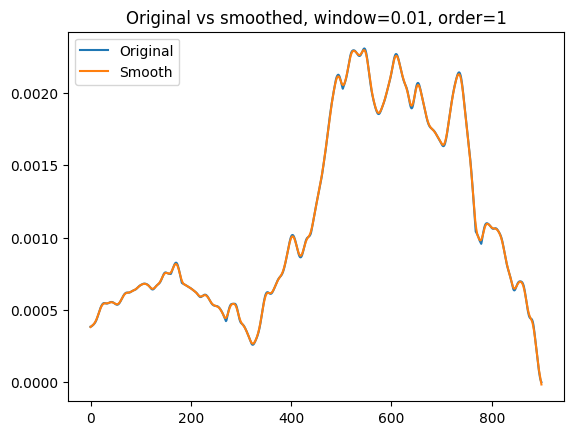

In [253]:



n,m=preprocessed_image.shape

im2s = Image2SignalDistribution()
x,y = im2s(preprocessed_image)
plt.plot(x,y,label="Original")
sgf = SavgolFilter(0.01,1)
x,y = sgf(x,y)
plt.plot(x,y,label="Smooth")
plt.legend()
plt.title(f"Original vs smoothed, window={sgf.window_size_percentage}, order={sgf.polyorder}")


[]


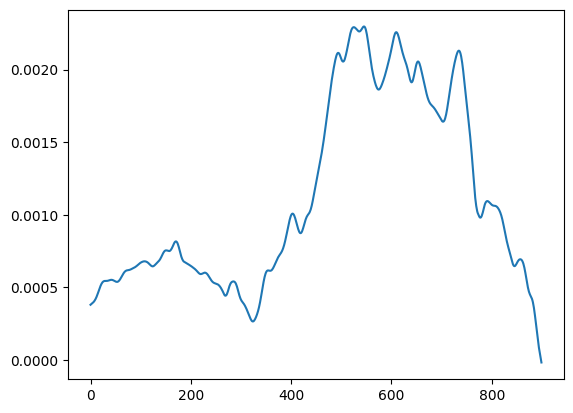

In [254]:

fp = FindPeaks(0.1,2,4)
peaks,_,_ = fp(x,y)
plt.plot(x,y)
plt.plot(peaks, y[peaks], "xr");
print(peaks) 


[530.96908209] [[8701.82030264]]
[737.86013681] [[5251.97355005]]
[160.4484657] [[8351.57784097]]


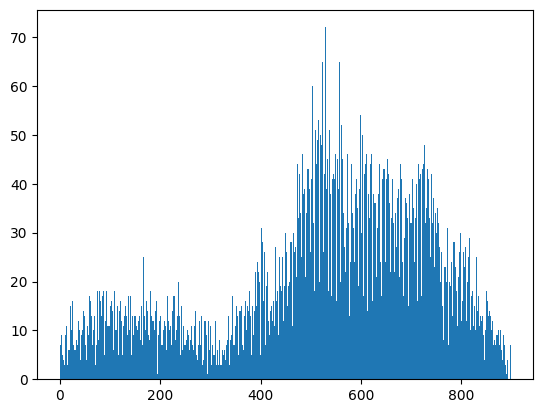

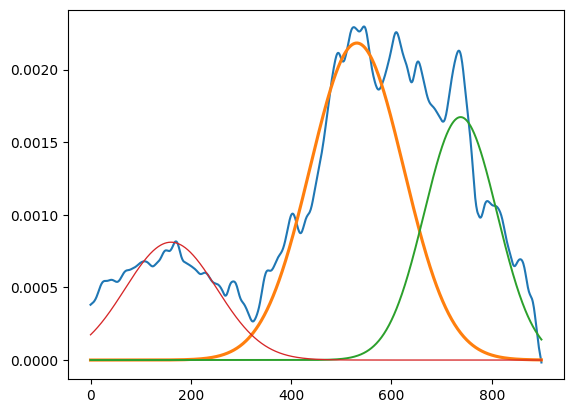

In [255]:
from util import pdf_to_samples,sample_pdf
from scipy.stats import norm

s = sample_pdf(x,y,10000)
plt.hist(s,bins=500)
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3,init_params="k-means++",n_init=4,max_iter=200).fit(s[:,None])
for mean,var in zip(gmm.means_,gmm.covariances_):
    print(mean,var)

def plot_gm(gmm,x,y):
    f,ax = plt.subplots(1)

    ax.plot(x,y)
    
    for i in range(len(gmm.weights_)):
        mu,sigma,pi=gmm.means_[i].squeeze(),gmm.covariances_[i].squeeze(),gmm.weights_[i]
        distribution = norm(loc=mu,scale=np.sqrt(sigma))
        p = distribution.pdf(x)*pi
        ax.plot(x,p,linewidth=4*pi+0.2,label = f"μ={mu:.2f},σ={sigma:.3f},π={pi:.2f}")
    # print(f"Final result:\n {gmm}")
plot_gm(gmm,x,y)

/home/facundoq/dev/spectrogen/peak_finding.py:67: RuntimeWarning: invalid value encountered in divide
  image[image<0.3]=0


[] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan

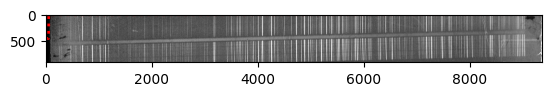

In [256]:


pipeline=Pipeline([
    BackgroundRemoval(spread_factor_multiplier=40),
    Image2SignalDistribution(),
    SavgolFilter(window_size_percentage=0.01,polyorder=1),
    FindPeaks(0.2,1.3,2),
])

# peaks,x,y = pipeline(image)
from numpy.lib.stride_tricks import as_strided

n,m = image.shape
window_size = 50
stride = window_size
def fullrow_windows(image,window_size,stride):
    n,m=image.shape

    for i in range(0,m-window_size+1,stride):
        start = i
        end = start+window_size
        yield image[:,start:end],i

center = np.zeros(m)
c = n//2
for window,i in fullrow_windows(image,window_size,stride):
    peaks,wx,wy = pipeline(window)
    print(peaks,wy)
    if len(peaks)>0:
        vals = wy[peaks]
        wy
        c = x[vals.argmax()]
    
    center[i:i+window_size]= c

plt.imshow(image,cmap="gray")
plt.plot(center,ls='dotted', linewidth=2, color='red')

# b = as_strided(image,shape=(n,window_size),strides=(0,1))
# print(b.shape)
# for slice in as_strided(image,shape=(n-1,window_size),strides=(1,window_size)):
#     print(slice.shape)


    